# TensorFlow 2.0 Project - Predicting Loan Repayment
# Part II: The Models
### A. J. Zerouali 2021/09/06

* This is the project in Section 25 of Pierian Data's DSML course. It's covered (with solutions) in Lectures 143-151.
* This is a continuation of the Lender's Club notebook where the exploratory data analysis is done.

## 0) Introduction



### Goal

Main question: **Given historical data on loans with information on whether or not the borrower defaulted (charge-off), can we build a model predicting wether or nor a borrower will repay their loan?**

This way in the future when we get a new potential customer we can assess whether or not they are likely to pay back the loan. Keep in mind classification metrics when evaluating the performance of your model! Our label here is the **"loan_status"** column.

### Comments and notes

1) I'm thinking of doing some hyperparameter optimization for the neural net of this project. The next line is from Google's HParams tutorial:

https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams.

I would like to avoid doing too much trial and error on my nets in general.

2) It would also be useful to paralellize the code. Here's the package to do this in Jupyter: https://ipyparallel.readthedocs.io/en/latest/. To use ipyparallel in Google Colab, have to install it using:
           
           !pip install ipyparallel
           
If I absolutely have to work with trial and error, might as well train several nets in parallel.

3) I might have to make models that don't include all categorical features.

## 1) Preliminaries

### a) Imports

* First the obvious imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
%load_ext tensorboard

* Here I'll load the clean data file that I made

In [3]:
df_lnclb_data = pd.read_csv("lenders_club_data_clean_AJZer.csv")

In [4]:
df_lnclb_data.columns

Index(['Unnamed: 0', 'loan_amnt', 'int_rate', 'installment', 'annual_inc',
       'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'mort_acc', 'pub_rec_bankruptcies', 'loan_status_int', 'term_int',
       'home_ownership_int', 'verification_status_int', 'purpose_int',
       'initial_list_status_int', 'application_type_int', 'emp_length_int'],
      dtype='object')

In [5]:
# Drop first column
df_lnclb_data = df_lnclb_data.drop(labels = 'Unnamed: 0', axis = 1)

In [6]:
df_lnclb_info = pd.read_csv("lending_club_info.csv")

* The second csv gives a description of the columns of our dataframe.

In [7]:
df_lnclb_data

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,loan_status_int,term_int,home_ownership_int,verification_status_int,purpose_int,initial_list_status_int,application_type_int,emp_length_int
0,10000.0,11.44,329.48,117000.0,26.24,16.0,0.0,36369.0,41.8,25.0,0.0,0.0,1,36,1,0,9,1,0,10.0
1,8000.0,11.99,265.68,65000.0,22.05,17.0,0.0,20131.0,53.3,27.0,3.0,0.0,1,36,2,0,0,0,0,4.0
2,15600.0,10.49,506.97,43057.0,12.79,13.0,0.0,11987.0,92.2,26.0,0.0,0.0,1,36,1,1,1,0,0,0.0
3,7200.0,6.49,220.65,54000.0,2.60,6.0,0.0,5472.0,21.5,13.0,0.0,0.0,1,36,1,0,1,0,0,6.0
4,24375.0,17.27,609.33,55000.0,33.95,13.0,0.0,24584.0,69.8,43.0,1.0,0.0,0,60,2,2,1,0,0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396025,10000.0,10.99,217.38,40000.0,15.63,6.0,0.0,1990.0,34.3,23.0,0.0,0.0,1,60,1,1,0,1,0,2.0
396026,21000.0,12.29,700.42,110000.0,21.45,6.0,0.0,43263.0,95.7,8.0,1.0,0.0,1,36,2,1,0,0,0,5.0
396027,5000.0,9.99,161.32,56500.0,17.56,15.0,0.0,32704.0,66.9,23.0,0.0,0.0,1,36,1,2,0,0,0,10.0
396028,21000.0,15.31,503.02,64000.0,15.88,9.0,0.0,15704.0,53.8,20.0,5.0,0.0,1,60,2,2,0,0,0,10.0


In [8]:
df_lnclb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   loan_amnt                396030 non-null  float64
 1   int_rate                 396030 non-null  float64
 2   installment              396030 non-null  float64
 3   annual_inc               396030 non-null  float64
 4   dti                      396030 non-null  float64
 5   open_acc                 396030 non-null  float64
 6   pub_rec                  396030 non-null  float64
 7   revol_bal                396030 non-null  float64
 8   revol_util               396030 non-null  float64
 9   total_acc                396030 non-null  float64
 10  mort_acc                 396030 non-null  float64
 11  pub_rec_bankruptcies     396030 non-null  float64
 12  loan_status_int          396030 non-null  int64  
 13  term_int                 396030 non-null  int64  
 14  home

In [29]:
df_lnclb_data["loan_status_int"].value_counts()

1    318357
0     77673
Name: loan_status_int, dtype: int64

* Next, import the needed data structures and functions from TensorFlow and Scikit Learn:

In [9]:
#### sklearn ####
# train-test-split
from sklearn.model_selection import train_test_split
# Min-max scaler
from sklearn.preprocessing import MinMaxScaler
# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

In [10]:
#### tensorflow.keras ####
# Sequential
from tensorflow.keras.models import Sequential
# Dense and dopout layers
from tensorflow.keras.layers import Dense, Dropout
# Callbacks: EarlyStopping and Tensorboard
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

### b) Data preprocessing

* Since we have a large dataset, we'll split it into training, validation and testing. The train_test_split will be for the validation set. The test set will be used for evaluation.
* Although I'll make several models, they'll all use the same data obviously.
* I'll set the training and validation at 360k entries with 33\% as validation, and the remainder as test data. 

In [11]:
# Training and validation
X = df_lnclb_data.iloc[:360000].drop(labels="loan_status_int", axis =1).values
y = df_lnclb_data["loan_status_int"].iloc[:360000].values

# Test data
X_Test = df_lnclb_data.iloc[360001:].drop(labels="loan_status_int", axis =1).values
y_Test = df_lnclb_data["loan_status_int"].iloc[360001:].values

* Apply train_test_split:

In [12]:
[X_train, X_val, y_train, y_val] = train_test_split(X, y, test_size=0.33, random_state=101)

* Create the MinMaxScaler and fit to training data:

In [13]:
data_scaler = MinMaxScaler()

X_train = data_scaler.fit_transform(X_train)

* Scale the validation and test data:

In [14]:
X_val = data_scaler.transform(X_val)
X_Test = data_scaler.transform(X_Test)

In [15]:
X_train.shape

(241200, 19)

In [52]:
X_val.shape

(118800, 19)

In [53]:
X_Test.shape

(36029, 19)

## 2) Building the model

### a) Model 1

* For this first model, we'll use all 19 features. Will set dropouts at 0.3.
* We'll use training batches of size $2^{14}=16384$.
* We'll optimize with ADAM and use the cross-entropy loss

In [16]:
# Instantiate Sequential
nn_model_01 = Sequential()

# Input Layer
nn_model_01.add(Dense(units = 19, activation = "relu"))
nn_model_01.add(Dropout(rate=0.3))

# Hidden layers
nn_model_01.add(Dense(units = 10, activation = "relu"))
nn_model_01.add(Dropout(rate=0.3))

nn_model_01.add(Dense(units = 5, activation = "relu"))
nn_model_01.add(Dropout(rate=0.3))

# Output layer with sigmoid activation
nn_model_01.add(Dense(units = 1, activation = "sigmoid"))

# Compile model:
nn_model_01.compile(optimizer = "adam", loss = "binary_crossentropy")

* Create EarlyStop

In [17]:
early_stop_01 = EarlyStopping(monitor='val_loss', patience=50, mode="min", verbose=1)

In [18]:
X_train.shape

(241200, 19)

In [20]:
X_val.shape

(118800, 19)

In [19]:
X_Test.shape

(36029, 19)

**TRAINING CODE**

* I'll skip the board for this first model

In [21]:
nn_model_01.fit(x = X_train, y=y_train, \
                validation_data=(X_val, y_val),\
                batch_size = 16384, validation_batch_size = 16384,
                epochs = 800, \
                callbacks=[early_stop_01],\
                verbose=1)

Epoch 1/800
15/15 [==============================] - 1s 33ms/step - loss: 0.6792 - val_loss: 0.6252
Epoch 2/800
15/15 [==============================] - 0s 21ms/step - loss: 0.6315 - val_loss: 0.5818
Epoch 3/800
15/15 [==============================] - 0s 19ms/step - loss: 0.6049 - val_loss: 0.5527
Epoch 4/800
15/15 [==============================] - 0s 19ms/step - loss: 0.5908 - val_loss: 0.5372
Epoch 5/800
15/15 [==============================] - 0s 19ms/step - loss: 0.5809 - val_loss: 0.5289
Epoch 6/800
15/15 [==============================] - 0s 18ms/step - loss: 0.5724 - val_loss: 0.5222
Epoch 7/800
15/15 [==============================] - 0s 18ms/step - loss: 0.5653 - val_loss: 0.5153
Epoch 8/800
15/15 [==============================] - 0s 18ms/step - loss: 0.5585 - val_loss: 0.5093
Epoch 9/800
15/15 [==============================] - 0s 19ms/step - loss: 0.5512 - val_loss: 0.5026
Epoch 10/800
15/15 [==============================] - 0s 19ms/step - loss: 0.5420 - val_loss: 0.4959

15/15 [==============================] - 0s 18ms/step - loss: 0.4674 - val_loss: 0.4596
Epoch 163/800
15/15 [==============================] - 0s 19ms/step - loss: 0.4674 - val_loss: 0.4594
Epoch 164/800
15/15 [==============================] - 0s 18ms/step - loss: 0.4664 - val_loss: 0.4591
Epoch 165/800
15/15 [==============================] - 0s 18ms/step - loss: 0.4669 - val_loss: 0.4592
Epoch 166/800
15/15 [==============================] - 0s 17ms/step - loss: 0.4666 - val_loss: 0.4592
Epoch 167/800
15/15 [==============================] - 0s 18ms/step - loss: 0.4668 - val_loss: 0.4592
Epoch 168/800
15/15 [==============================] - 0s 18ms/step - loss: 0.4667 - val_loss: 0.4592
Epoch 169/800
15/15 [==============================] - 0s 18ms/step - loss: 0.4664 - val_loss: 0.4592
Epoch 170/800
15/15 [==============================] - 0s 18ms/step - loss: 0.4665 - val_loss: 0.4592
Epoch 171/800
15/15 [==============================] - 0s 18ms/step - loss: 0.4663 - val_loss: 0

15/15 [==============================] - 0s 17ms/step - loss: 0.4631 - val_loss: 0.4582
Epoch 323/800
15/15 [==============================] - 0s 18ms/step - loss: 0.4626 - val_loss: 0.4578
Epoch 324/800
15/15 [==============================] - 0s 18ms/step - loss: 0.4625 - val_loss: 0.4579
Epoch 325/800
15/15 [==============================] - 0s 17ms/step - loss: 0.4630 - val_loss: 0.4579
Epoch 326/800
15/15 [==============================] - 0s 17ms/step - loss: 0.4631 - val_loss: 0.4577
Epoch 327/800
15/15 [==============================] - 0s 18ms/step - loss: 0.4627 - val_loss: 0.4576
Epoch 328/800
15/15 [==============================] - 0s 18ms/step - loss: 0.4630 - val_loss: 0.4580
Epoch 329/800
15/15 [==============================] - 0s 17ms/step - loss: 0.4627 - val_loss: 0.4578
Epoch 330/800
15/15 [==============================] - 0s 17ms/step - loss: 0.4626 - val_loss: 0.4582
Epoch 331/800
15/15 [==============================] - 0s 18ms/step - loss: 0.4626 - val_loss: 0

<AxesSubplot:>

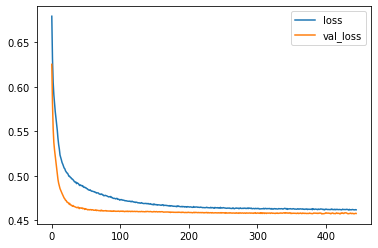

In [22]:
pd.DataFrame(nn_model_01.history.history).plot()

* Let's look at the predictions for this model:

In [49]:
z_pred_01 = (nn_model_01.predict(X_Test) > 0.8).astype("int32")

* Let's look at the confusion matrix and classification report:

In [50]:
print(classification_report(y_true = y_Test, y_pred=z_pred_01))

              precision    recall  f1-score   support

           0       0.34      0.55      0.42      7147
           1       0.87      0.74      0.80     28882

    accuracy                           0.70     36029
   macro avg       0.61      0.65      0.61     36029
weighted avg       0.77      0.70      0.72     36029



In [51]:
print(confusion_matrix(y_true = y_Test, y_pred=z_pred_01))

[[ 3941  3206]
 [ 7527 21355]]


* This is bad. Here are the number of ones in each y vector:

In [31]:
y_train.sum()

193979

In [33]:
y_val.sum()

95495

In [32]:
y_Test.sum()

28882

* In the test data, there's an overwhelming number of ones. Should I shuffle the data more?

**Comments (21/09/06; 13:00)**
* There's a huge problem with this model... It doesn't predict defaults (0's) accurately. I changed the sigmoid probability  threshold from 0.5 to 0.6, 0.7, 0.75, 0.8, 0.85, 0.9. No results are good here.
* Save the model for now (21/09/06, 13:10):

In [55]:
nn_model_01.save("Lenders_Club_mdl-01_2HL_2109061245.h5")

### b) Model 2

In [ ]:
# Instantiate Sequential
nn_model_02 = Sequential()

# Input Layer
nn_model_02.add(Dense(units = 19, activation = "relu"))
nn_model_02.add(Dropout(rate=0.3))

# Hidden layer
nn_model_02.add(Dense(units = 10, activation = "relu"))
nn_model_02.add(Dropout(rate=0.3))

# Output layer with sigmoid activation
nn_model_02.add(Dense(units = 1, activation = "sigmoid"))

# Compile model:
nn_model_02.compile(optimizer = "adam", loss = "binary_crossentropy")

## 3) Evaluation and prediction

## Appendix

### More on data